                                            Stock Price Prediction
We'll create a machine learning algorithm to predict if the stock price will increase tomorrow.
If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

Downloading the data

In [1]:
import yfinance as yf
import os
import json
import pandas as pd


In [2]:
msft = yf.Ticker("MSFT")
msft = msft.history(period="max")

In [3]:
# Display microsoft stock price history so we can look at the structure of the data
msft.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062980,0.064610,0.062980,0.064067,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.064067,0.064609,0.061894,0.062437,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062437,0.062980,0.060809,0.061351,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

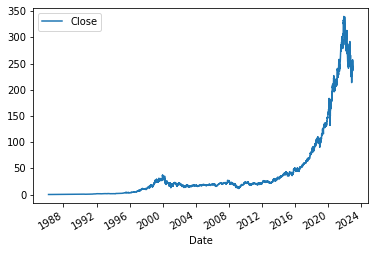

In [4]:
# Visualize microsoft stock prices
msft.plot.line(y="Close", use_index=True)

                                      Preparing the data
We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1 and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! 

In [5]:
# Ensure we know the actual closing price
data = msft[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})


In [6]:
# Setup our target.  This identifies if the price went up or down
data["Target"] = msft.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [7]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft.copy()
msft_prev = msft.shift(1)

In [8]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [9]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 00:00:00-05:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 00:00:00-05:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064610,0.062980
1986-03-19 00:00:00-05:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894
1986-03-20 00:00:00-05:00,0.059723,0.0,0.061351,4.789440e+07,0.062437,0.062980,0.060809


                                         machine learning model
We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.                                        

In [10]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [11]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4861111111111111

<AxesSubplot:xlabel='Date'>

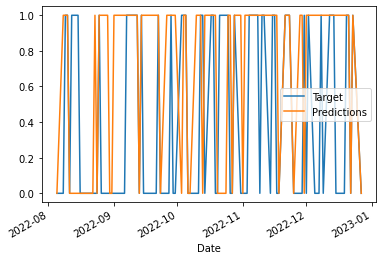

In [12]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

                                                 Backtesting
We'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting.In the backtesting function, we will:
Split the training and test data
Train a model
Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives.
By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high.
We'll make fewer trades, but will have a lower potential for losses.    

In [14]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [15]:
predictions = backtest(data, model, predictors)

In [16]:
predictions["Predictions"].value_counts()

0.0    7501
1.0     772
Name: Predictions, dtype: int64

                                           Improving accuracy
The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.                                           

In [17]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [18]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [19]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5571955719557196

In [21]:
predictions["Predictions"].value_counts()

0.0    7637
1.0     271
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

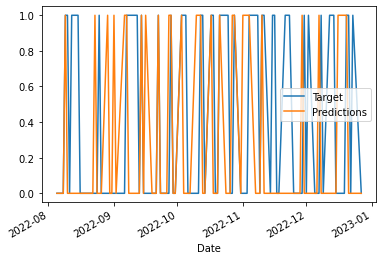

In [22]:
predictions.iloc[-100:].plot()